### Create H2O cloud

In [17]:
### Introduction
#This tutorial shows how a H2O [Deep Learning](http://en.wikipedia.org/wiki/Deep_learning) model can be used to do supervised classification and regression. A great tutorial about Deep Learning is given by Quoc Le [here](http://cs.stanford.edu/~quocle/tutorial1.pdf) and [here](http://cs.stanford.edu/~quocle/tutorial2.pdf). This tutorial covers usage of H2O from R. A python version of this tutorial will be available as well in a separate document. This file is available in plain R, R markdown and regular markdown formats, and the plots are available as PDF files. All documents are available [on Github](https://github.com/h2oai/h2o-tutorials/tree/master/tutorials/deeplearning/).
#
#If run from plain R, execute R in the directory of this script. If run from RStudio, be sure to setwd() to the location of this script. h2o.init() starts H2O in R's current working directory. h2o.importFile() looks for files from the perspective of where H2O was started.
#

library(h2o)
h2o.init(nthreads=-1, max_mem_size="2G")
h2o.removeAll() 

 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         2 days 18 hours 
    H2O cluster version:        3.10.3.6 
    H2O cluster version age:    1 month and 16 days  
    H2O cluster name:           H2O_started_from_R_jovyan_qjv229 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   1.56 GB 
    H2O cluster total cores:    4 
    H2O cluster allowed cores:  4 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    R Version:                  R version 3.3.2 (2016-10-31) 

[1] 0


### Read csv and split teh dataset 

In [18]:
### Cover Type Dataset

df <- h2o.importFile(path = normalizePath("data/covtype.full.csv"))
dim(df)
#df
splits <- h2o.splitFrame(df, c(0.6,0.2), seed=1234)
train  <- h2o.assign(splits[[1]], "train.hex") # 60%
valid  <- h2o.assign(splits[[2]], "valid.hex") # 20%
test   <- h2o.assign(splits[[3]], "test.hex")  # 20%
par(mfrow=c(1,1)) # reset canvas

  |======================================================================| 100%


[1] 581012     13

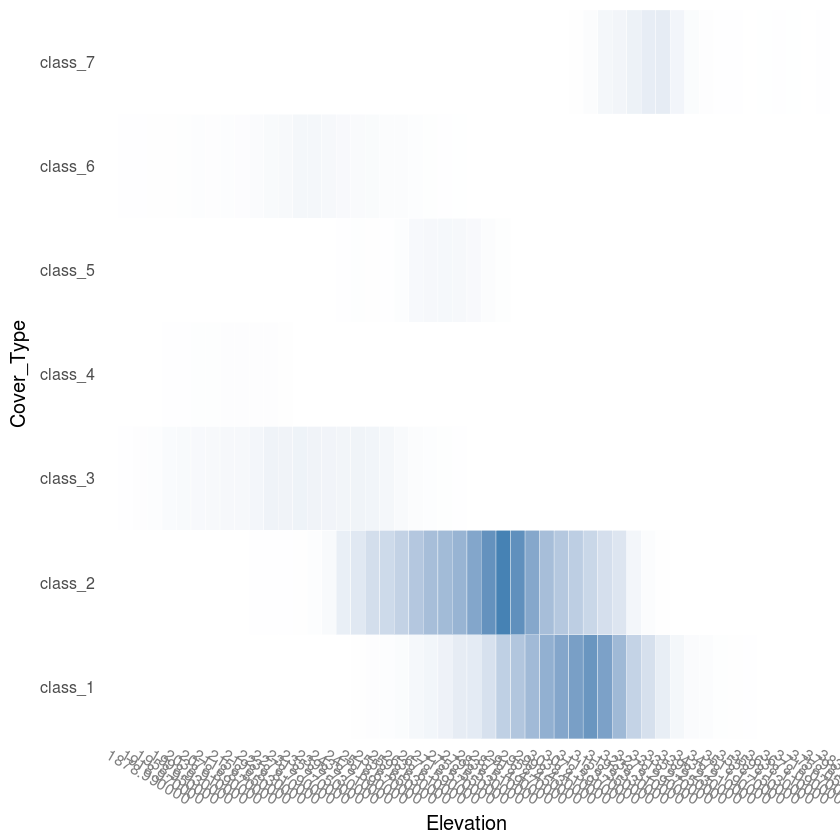

In [19]:
plot(h2o.tabulate(df, "Elevation",                       "Cover_Type"))

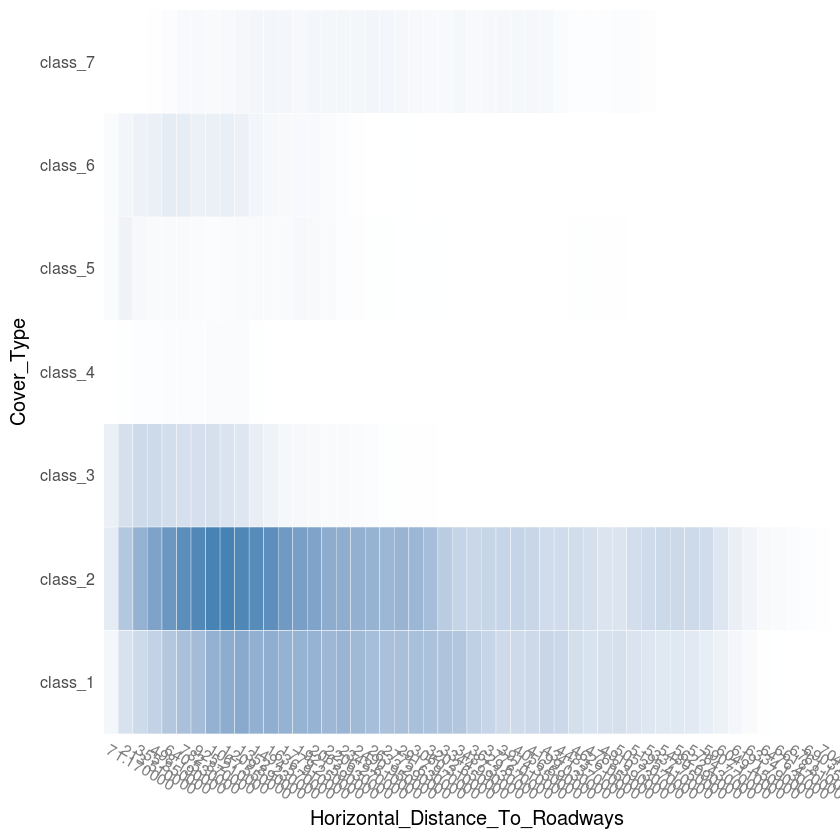

In [20]:
plot(h2o.tabulate(df, "Horizontal_Distance_To_Roadways", "Cover_Type"))

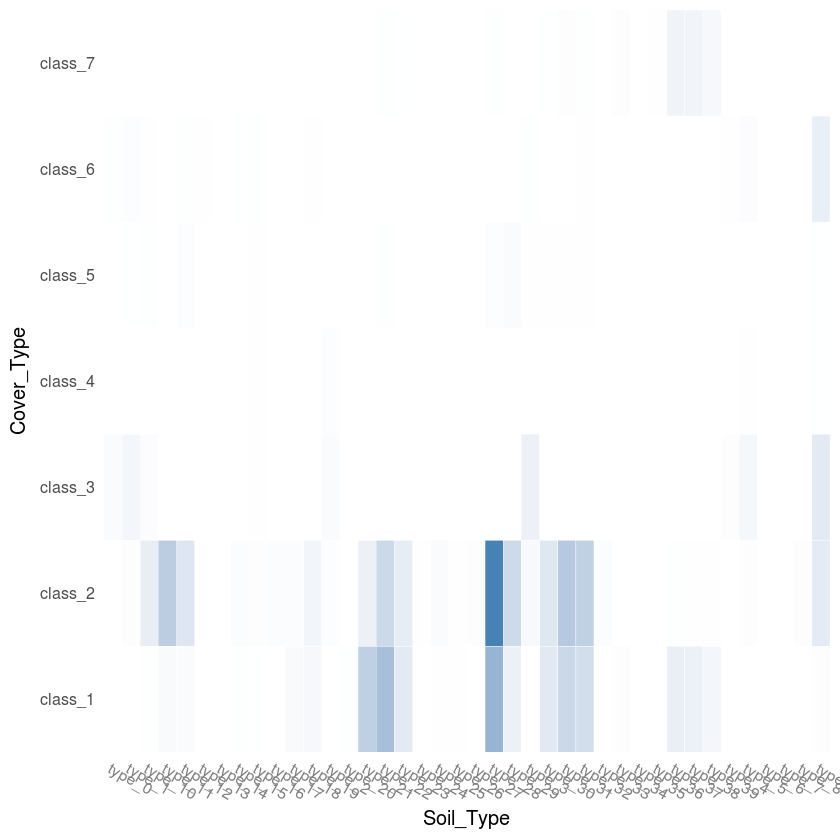

In [21]:
plot(h2o.tabulate(df, "Soil_Type", "Cover_Type"))

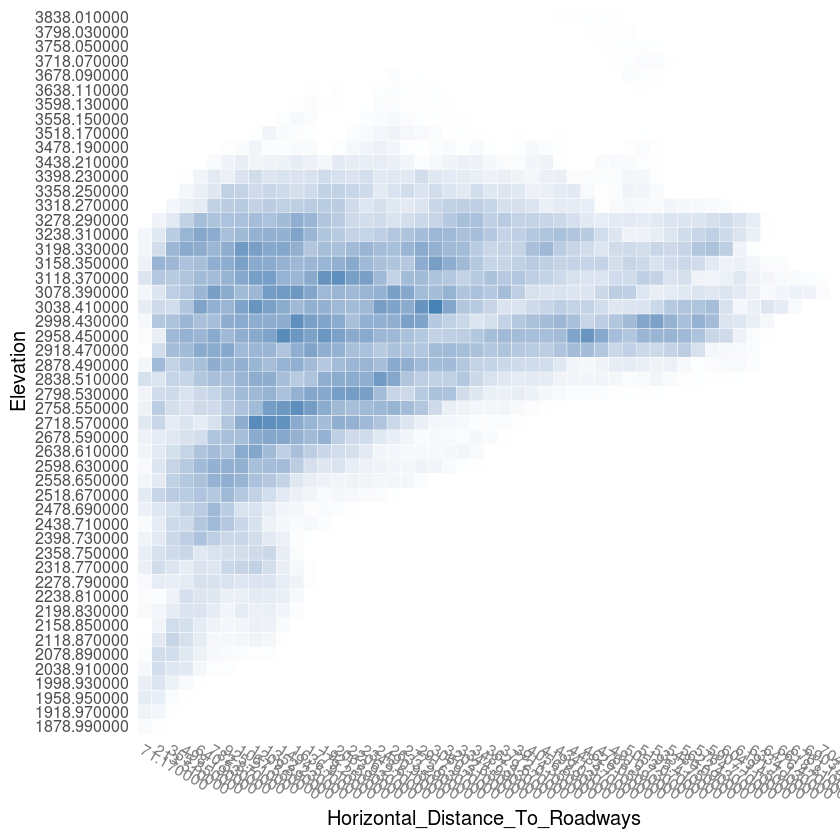

In [22]:
plot(h2o.tabulate(df, "Horizontal_Distance_To_Roadways", "Elevation" ))

### First Run of H2O Deep Learning

The aim is to predict the `Cover_Type` column, a categorical feature with 7 levels, and the Deep Learning model will be tasked to perform (multi-class) classification. It uses the other 12 predictors of the dataset, of which 10 are numerical, and 2 are categorical with a total of 44 levels. We can expect the Deep Learning model to have 56 input neurons (after automatic one-hot encoding).


In [23]:
#### 
#Let's run our first Deep Learning model on the covtype dataset. 

response <- "Cover_Type"
predictors <- setdiff(names(df), response)
predictors
#
#To keep it fast, we only run for one epoch (one pass over the training data).
#
m1 <- h2o.deeplearning(
  model_id="dl_model_first", 
  training_frame=train, 
  validation_frame=valid,   ## validation dataset: used for scoring and early stopping
  x=predictors,
  y=response,
  #activation="Rectifier",  ## default
  #hidden=c(200,200),       ## default: 2 hidden layers with 200 neurons each
  epochs=1,
  variable_importances=T    ## not enabled by default
)
summary(m1)
#
#Inspect the model in [Flow](http://localhost:54321/) for more information about model building etc. by issuing a cell with the content `getModel "dl_model_first"`, and pressing Ctrl-Enter.
#


[1] "Elevation"                          "Aspect"                            
 [3] "Slope"                              "Horizontal_Distance_To_Hydrology"  
 [5] "Vertical_Distance_To_Hydrology"     "Horizontal_Distance_To_Roadways"   
 [7] "Hillshade_9am"                      "Hillshade_Noon"                    
 [9] "Hillshade_3pm"                      "Horizontal_Distance_To_Fire_Points"
[11] "Wilderness_Area"                    "Soil_Type"

  |======================================================================| 100%
Model Details:

H2OMultinomialModel: deeplearning
Model Key:  dl_model_first 
Status of Neuron Layers: predicting Cover_Type, 7-class classification, multinomial distribution, CrossEntropy loss, 53,007 weights/biases, 634.4 KB, 383,504 training samples, mini-batch size 1
  layer units      type dropout       l1       l2 mean_rate rate_rms momentum
1     1    56     Input  0.00 %                                              
2     2   200 Rectifier  0.00 % 0.000000 0.000000  0.060185 0.229082 0.000000
3     3   200 Rectifier  0.00 % 0.000000 0.000000  0.009364 0.008344 0.000000
4     4     7   Softmax         0.000000 0.000000  0.125367 0.310942 0.000000
  mean_weight weight_rms mean_bias bias_rms
1                                          
2   -0.011407   0.118358  0.013626 0.108041
3   -0.026246   0.122438  0.708538 0.398949
4   -0.350525   0.502231 -0.513987 0.142469

H2OMultinomialMetrics: deeplearning
*

#### Variable Importances
Variable importances for Neural Network models are notoriously difficult to compute, and there are many [pitfalls](ftp://ftp.sas.com/pub/neural/importance.html). H2O Deep Learning has implemented the method of [Gedeon](http://cs.anu.edu.au/~./Tom.Gedeon/pdfs/ContribDataMinv2.pdf), and returns relative variable importances in descending order of importance.


In [24]:
head(as.data.frame(h2o.varimp(m1)))

variable,relative_importance,scaled_importance,percentage
Wilderness_Area.area_0,1.0000000,1.0000000,0.03196108
Horizontal_Distance_To_Roadways,0.9432643,0.9432643,0.03014775
Horizontal_Distance_To_Fire_Points,0.8963255,0.8963255,0.02864753
Elevation,0.8876461,0.8876461,0.02837013
Wilderness_Area.area_2,0.7617335,0.7617335,0.02434583
Wilderness_Area.area_1,0.7393799,0.7393799,0.02363138


#### Early Stopping
Now we run another, smaller network, and we let it stop automatically once the misclassification rate 
converges (specifically, if the moving average of length 2 does not improve by at least 1% for 2 consecutive scoring events). 
We also sample the validation set to 10,000 rows for faster scoring.


  |======================================================================| 100%
Model Details:

H2OMultinomialModel: deeplearning
Model Key:  dl_model_faster 
Status of Neuron Layers: predicting Cover_Type, 7-class classification, multinomial distribution, CrossEntropy loss, 4,167 weights/biases, 58.1 KB, 2,901,355 training samples, mini-batch size 1
  layer units      type dropout       l1       l2 mean_rate rate_rms momentum
1     1    56     Input  0.00 %                                              
2     2    32 Rectifier  0.00 % 0.000000 0.000000  0.045262 0.206260 0.000000
3     3    32 Rectifier  0.00 % 0.000000 0.000000  0.000411 0.000223 0.000000
4     4    32 Rectifier  0.00 % 0.000000 0.000000  0.001001 0.000970 0.000000
5     5     7   Softmax         0.000000 0.000000  0.138319 0.326980 0.000000
  mean_weight weight_rms mean_bias bias_rms
1                                          
2   -0.010346   0.267075  0.231581 0.214652
3   -0.063940   0.342303  0.647585 0.690351
4  

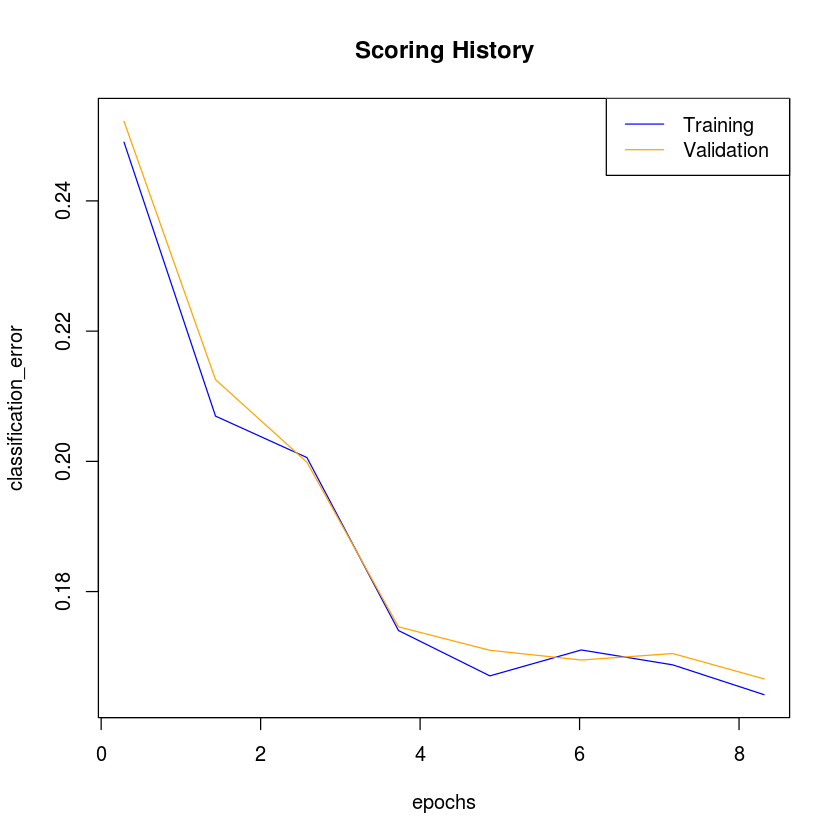

In [25]:
m2 <- h2o.deeplearning(
  model_id="dl_model_faster", 
  training_frame=train, 
  validation_frame=valid,
  x=predictors,
  y=response,
  hidden=c(32,32,32),                  ## small network, runs faster
  epochs=1000000,                      ## hopefully converges earlier...
  score_validation_samples=10000,      ## sample the validation dataset (faster)
  stopping_rounds=2,
  stopping_metric="misclassification", ## could be "MSE","logloss","r2"
  stopping_tolerance=0.01
)
summary(m2)
plot(m2)


#### Adaptive Learning Rate
By default, H2O Deep Learning uses an adaptive learning rate ([ADADELTA](http://arxiv.org/pdf/1212.5701v1.pdf)) for its stochastic gradient descent optimization. There are only two tuning parameters for this method: `rho` and `epsilon`, which balance the global and local search efficiencies. `rho` is the similarity to prior weight updates (similar to momentum), and `epsilon` is a parameter that prevents the optimization to get stuck in local optima. Defaults are `rho=0.99` and `epsilon=1e-8`. For cases where convergence speed is very important, it might make sense to perform a few runs to optimize these two parameters (e.g., with `rho in c(0.9,0.95,0.99,0.999)` and `epsilon in c(1e-10,1e-8,1e-6,1e-4)`). Of course, as always with grid searches, caution has to be applied when extrapolating grid search results to a different parameter regime (e.g., for more epochs or different layer topologies or activation functions, etc.).

If `adaptive_rate` is disabled, several manual learning rate parameters become important: `rate`, `rate_annealing`, `rate_decay`, `momentum_start`, `momentum_ramp`, `momentum_stable` and `nesterov_accelerated_gradient`, the discussion of which we leave to [H2O Deep Learning booklet](http://h2o.ai/resources/).

Tuning
With some tuning, it is possible to obtain less than 10% test set error rate in about one minute. Error rates of below 5% are possible with larger models. Note that deep tree methods can be more effective for this dataset than Deep Learning, as they directly partition the space into sectors, which seems to be needed here.


In [26]:
m3 <- h2o.deeplearning(
  model_id="dl_model_tuned", 
  training_frame=train, 
  validation_frame=valid, 
  x=predictors, 
  y=response, 
  overwrite_with_best_model=F,    ## Return the final model after 10 epochs, even if not the best
  hidden=c(128,128,128),          ## more hidden layers -> more complex interactions
  epochs=10,                      ## to keep it short enough
  score_validation_samples=10000, ## downsample validation set for faster scoring
  score_duty_cycle=0.025,         ## don't score more than 2.5% of the wall time
  adaptive_rate=F,                ## manually tuned learning rate
  rate=0.01, 
  rate_annealing=2e-6,            
  momentum_start=0.2,             ## manually tuned momentum
  momentum_stable=0.4, 
  momentum_ramp=1e7, 
  l1=1e-5,                        ## add some L1/L2 regularization
  l2=1e-5,
  max_w2=10                       ## helps stability for Rectifier
) 
summary(m3)
#
#Let's compare the training error with the validation and test set errors
#
h2o.performance(m3, train=T)          ## sampled training data (from model building)
h2o.performance(m3, valid=T)          ## sampled validation data (from model building)
h2o.performance(m3, newdata=train)    ## full training data
h2o.performance(m3, newdata=valid)    ## full validation data
h2o.performance(m3, newdata=test)     ## full test data
#
#To confirm that the reported confusion matrix on the validation set (here, the test set) was correct, we make a prediction on the test set and compare the confusion matrices explicitly:
#
pred <- h2o.predict(m3, test)
pred
test$Accuracy <- pred$predict == test$Cover_Type
1-mean(test$Accuracy)
#    

  |======================================================================| 100%
Model Details:

H2OMultinomialModel: deeplearning
Model Key:  dl_model_tuned 
Status of Neuron Layers: predicting Cover_Type, 7-class classification, multinomial distribution, CrossEntropy loss, 41,223 weights/biases, 333.2 KB, 3,492,906 training samples, mini-batch size 1
  layer units      type dropout       l1       l2 mean_rate rate_rms momentum
1     1    56     Input  0.00 %                                              
2     2   128 Rectifier  0.00 % 0.000010 0.000010  0.001252 0.000000 0.269858
3     3   128 Rectifier  0.00 % 0.000010 0.000010  0.001252 0.000000 0.269858
4     4   128 Rectifier  0.00 % 0.000010 0.000010  0.001252 0.000000 0.269858
5     5     7   Softmax         0.000010 0.000010  0.001252 0.000000 0.269858
  mean_weight weight_rms mean_bias bias_rms
1                                          
2   -0.013098   0.320820 -0.043497 0.304857
3   -0.055427   0.220547  0.868522 0.377048
4 

H2OMultinomialMetrics: deeplearning
** Reported on training data. **
** Metrics reported on temporary training frame with 10118 samples **

Training Set Metrics: 

MSE: (Extract with `h2o.mse`) 0.05617202
RMSE: (Extract with `h2o.rmse`) 0.2370064
Logloss: (Extract with `h2o.logloss`) 0.186396
Mean Per-Class Error: 0.1217631
Confusion Matrix: Extract with `h2o.confusionMatrix(<model>,train = TRUE)`)
Confusion Matrix: vertical: actual; across: predicted
        class_1 class_2 class_3 class_4 class_5 class_6 class_7  Error
class_1    3426     252       0       0       6       0      35 0.0788
class_2     254    4658      11       0      22       7       1 0.0596
class_3       1      13     562       7       0      35       0 0.0906
class_4       0       0       1      43       0       2       0 0.0652
class_5       4      42       2       0     101       0       0 0.3221
class_6       0       8      38       0       1     240       0 0.1638
class_7      24       1       0       0       0

H2OMultinomialMetrics: deeplearning
** Reported on validation data. **
** Metrics reported on temporary validation frame with 10011 samples **

Validation Set Metrics: 

MSE: (Extract with `h2o.mse`) 0.06357797
RMSE: (Extract with `h2o.rmse`) 0.2521467
Logloss: (Extract with `h2o.logloss`) 0.213068
Mean Per-Class Error: 0.1273092
Confusion Matrix: Extract with `h2o.confusionMatrix(<model>,valid = TRUE)`)
Confusion Matrix: vertical: actual; across: predicted
        class_1 class_2 class_3 class_4 class_5 class_6 class_7  Error
class_1    3364     286       0       0       8       0      19 0.0851
class_2     302    4520       9       0      21       6       2 0.0700
class_3       0      18     561       8       0      31       0 0.0922
class_4       0       0       6      47       0       0       0 0.1132
class_5       2      38       2       0     120       0       0 0.2593
class_6       1      20      37       1       1     232       0 0.2055
class_7      22       1       0       0  

H2OMultinomialMetrics: deeplearning

Test Set Metrics: 

MSE: (Extract with `h2o.mse`) 0.05637214
RMSE: (Extract with `h2o.rmse`) 0.2374282
Logloss: (Extract with `h2o.logloss`) 0.1866501
Mean Per-Class Error: 0.1199407
Confusion Matrix: Extract with `h2o.confusionMatrix(<model>, <data>)`)
Confusion Matrix: vertical: actual; across: predicted
        class_1 class_2 class_3 class_4 class_5 class_6 class_7  Error
class_1  117404    8665       0       0     100       6     945 0.0764
class_2    8997  160006     368       2     641     266      62 0.0607
class_3      15     428   19781     205      31     982       0 0.0775
class_4       1       0     201    1413       0      43       0 0.1478
class_5      79    1052      85       0    4483      21       0 0.2163
class_6      53     482    1228      61      15    8594       0 0.1763
class_7     931     111       0       0       0       0   11258 0.0847
Totals   127480  170744   21663    1681    5270    9912   12265 0.0747
                

H2OMultinomialMetrics: deeplearning

Test Set Metrics: 

MSE: (Extract with `h2o.mse`) 0.06282037
RMSE: (Extract with `h2o.rmse`) 0.2506399
Logloss: (Extract with `h2o.logloss`) 0.2092748
Mean Per-Class Error: 0.1341546
Confusion Matrix: Extract with `h2o.confusionMatrix(<model>, <data>)`)
Confusion Matrix: vertical: actual; across: predicted
        class_1 class_2 class_3 class_4 class_5 class_6 class_7  Error
class_1   38880    3240       1       0      52       4     323 0.0852
class_2    3270   52614     124       2     243     101      26 0.0668
class_3      10     181    6506      82      12     352       0 0.0892
class_4       0       0      72     475       0      15       0 0.1548
class_5      40     387      37       0    1399       7       0 0.2519
class_6      17     188     453      26       8    2772       0 0.1998
class_7     338      37       0       0       0       0    3724 0.0915
Totals    42555   56647    7193     585    1714    3251    4073 0.0832
                

H2OMultinomialMetrics: deeplearning

Test Set Metrics: 

MSE: (Extract with `h2o.mse`) 0.06214864
RMSE: (Extract with `h2o.rmse`) 0.2492963
Logloss: (Extract with `h2o.logloss`) 0.2059242
Mean Per-Class Error: 0.1302595
Confusion Matrix: Extract with `h2o.confusionMatrix(<model>, <data>)`)
Confusion Matrix: vertical: actual; across: predicted
        class_1 class_2 class_3 class_4 class_5 class_6 class_7  Error
class_1   38646    3186       0       0      44       2     342 0.0847
class_2    3344   52688     146       2     246     122      31 0.0688
class_3       5     186    6521      80      17     360       0 0.0904
class_4       2       2      55     449       0      19       0 0.1480
class_5      25     361      30       0    1477      10       0 0.2239
class_6      21     177     447      28       6    2791       0 0.1957
class_7     367      46       0       0       0       0    3698 0.1005
Totals    42410   56646    7199     559    1790    3304    4071 0.0837
                

  |======================================================================| 100%


  predict      class_1      class_2      class_3      class_4      class_5
1 class_2 3.861821e-01 0.6137390239 2.961081e-05 9.821604e-07 4.269572e-05
2 class_1 9.962242e-01 0.0036862555 1.647905e-05 4.374610e-06 1.473707e-05
3 class_1 9.997911e-01 0.0002087107 3.406214e-10 5.214139e-08 2.073088e-10
4 class_1 9.919345e-01 0.0080254731 3.487553e-07 4.341918e-06 3.685149e-07
5 class_2 9.866539e-03 0.9897492265 1.486318e-05 1.406778e-04 1.337014e-04
6 class_5 1.880863e-05 0.0123778077 1.614000e-05 1.264604e-09 9.875872e-01
       class_6      class_7
1 2.955155e-06 2.617755e-06
2 5.729844e-06 4.825180e-05
3 8.693695e-10 1.025505e-07
4 3.111472e-07 3.460757e-05
5 8.126398e-05 1.372780e-05
6 6.353491e-10 8.530925e-09

[115979 rows x 8 columns] 

[1] 0.08371343

### Hyper-parameter Tuning with Grid Search
Since there are a lot of parameters that can impact model accuracy, hyper-parameter tuning is especially important for Deep Learning:

For speed, we will only train on the first 10,000 rows of the training dataset:
 
The simplest hyperparameter search method is a brute-force scan of the full Cartesian product of all combinations specified by a grid search:



In [27]:
sampled_train=train[1:10000,]
hyper_params <- list(
  hidden=list(c(32,32,32),c(64,64)),
  input_dropout_ratio=c(0,0.05),
  rate=c(0.01,0.02),
  rate_annealing=c(1e-8,1e-7,1e-6)
)
hyper_params

$hidden
$hidden[[1]]
[1] 32 32 32

$hidden[[2]]
[1] 64 64


$input_dropout_ratio
[1] 0.00 0.05

$rate
[1] 0.01 0.02

$rate_annealing
[1] 1e-08 1e-07 1e-06

In [28]:
grid <- h2o.grid(
  algorithm="deeplearning",
  grid_id="dl_grid", 
  training_frame=sampled_train,
  validation_frame=valid, 
  x=predictors, 
  y=response,
  epochs=10,
  stopping_metric="misclassification",
  stopping_tolerance=1e-2,        ## stop when misclassification does not improve by >=1% for 2 scoring events
  stopping_rounds=2,
  score_validation_samples=10000, ## downsample validation set for faster scoring
  score_duty_cycle=0.025,         ## don't score more than 2.5% of the wall time
  adaptive_rate=F,                ## manually tuned learning rate
  momentum_start=0.5,             ## manually tuned momentum
  momentum_stable=0.9, 
  momentum_ramp=1e7, 
  l1=1e-5,
  l2=1e-5,
  activation=c("Rectifier"),
  max_w2=10,                      ## can help improve stability for Rectifier
  hyper_params=hyper_params
)
grid
#                                
#Let's see which model had the lowest validation error:
#
grid <- h2o.getGrid("dl_grid",sort_by="err",decreasing=FALSE)
grid

## To see what other "sort_by" criteria are allowed
#grid <- h2o.getGrid("dl_grid",sort_by="wrong_thing",decreasing=FALSE)

## Sort by logloss
h2o.getGrid("dl_grid",sort_by="logloss",decreasing=FALSE)

## Find the best model and its full set of parameters
grid@summary_table[1,]
best_model <- h2o.getModel(grid@model_ids[[1]])
best_model

print(best_model@allparameters)
print(h2o.performance(best_model, valid=T))
print(h2o.logloss(best_model, valid=T))

  |======================================================================| 100%


H2O Grid Details

Grid ID: dl_grid 
Used hyper parameters: 
  -  hidden 
  -  input_dropout_ratio 
  -  rate 
  -  rate_annealing 
Number of models: 24 
Number of failed models: 0 

Hyper-Parameter Search Summary: ordered by increasing logloss
    hidden input_dropout_ratio rate rate_annealing        model_ids
1 [64, 64]                 0.0 0.01         1.0E-6 dl_grid_model_17
2 [64, 64]                0.05 0.01         1.0E-8  dl_grid_model_3
3 [64, 64]                 0.0 0.02         1.0E-8  dl_grid_model_5
4 [64, 64]                 0.0 0.01         1.0E-8  dl_grid_model_1
5 [64, 64]                 0.0 0.02         1.0E-6 dl_grid_model_21
             logloss
1 0.5600391453565798
2 0.5653467258226916
3 0.5736902631918644
4 0.5814472549373565
5 0.5834421192465598

---
         hidden input_dropout_ratio rate rate_annealing        model_ids
19 [32, 32, 32]                 0.0 0.02         1.0E-6 dl_grid_model_20
20 [32, 32, 32]                0.05 0.02         1.0E-6 dl_grid_model_2

H2O Grid Details

Grid ID: dl_grid 
Used hyper parameters: 
  -  hidden 
  -  input_dropout_ratio 
  -  rate 
  -  rate_annealing 
Number of models: 24 
Number of failed models: 0 

Hyper-Parameter Search Summary: ordered by increasing err
        hidden input_dropout_ratio rate rate_annealing        model_ids
1     [64, 64]                 0.0 0.01         1.0E-8  dl_grid_model_1
2     [64, 64]                 0.0 0.02         1.0E-6 dl_grid_model_21
3 [32, 32, 32]                 0.0 0.01         1.0E-6 dl_grid_model_16
4     [64, 64]                 0.0 0.02         1.0E-8  dl_grid_model_5
5     [64, 64]                0.05 0.01         1.0E-8  dl_grid_model_3
                  err
1    0.23773173391494
2  0.2392957182873149
3 0.24047186932849365
4 0.24115755627009647
5  0.2429514097180564

---
         hidden input_dropout_ratio rate rate_annealing        model_ids
19 [32, 32, 32]                0.05 0.02         1.0E-6 dl_grid_model_22
20 [32, 32, 32]                 0.0 0.02     

H2O Grid Details

Grid ID: dl_grid 
Used hyper parameters: 
  -  hidden 
  -  input_dropout_ratio 
  -  rate 
  -  rate_annealing 
Number of models: 24 
Number of failed models: 0 

Hyper-Parameter Search Summary: ordered by increasing logloss
    hidden input_dropout_ratio rate rate_annealing        model_ids
1 [64, 64]                 0.0 0.01         1.0E-6 dl_grid_model_17
2 [64, 64]                0.05 0.01         1.0E-8  dl_grid_model_3
3 [64, 64]                 0.0 0.02         1.0E-8  dl_grid_model_5
4 [64, 64]                 0.0 0.01         1.0E-8  dl_grid_model_1
5 [64, 64]                 0.0 0.02         1.0E-6 dl_grid_model_21
             logloss
1 0.5600391453565798
2 0.5653467258226916
3 0.5736902631918644
4 0.5814472549373565
5 0.5834421192465598

---
         hidden input_dropout_ratio rate rate_annealing        model_ids
19 [32, 32, 32]                 0.0 0.02         1.0E-6 dl_grid_model_20
20 [32, 32, 32]                0.05 0.02         1.0E-6 dl_grid_model_2

hidden,input_dropout_ratio,rate,rate_annealing,model_ids,err
"[64, 64]",0.0,0.01,1.0E-8,dl_grid_model_1,0.23773173391494


Model Details:

H2OMultinomialModel: deeplearning
Model ID:  dl_grid_model_1 
Status of Neuron Layers: predicting Cover_Type, 7-class classification, multinomial distribution, CrossEntropy loss, 8,263 weights/biases, 71.5 KB, 100,000 training samples, mini-batch size 1
  layer units      type dropout       l1       l2 mean_rate rate_rms momentum
1     1    56     Input  0.00 %                                              
2     2    64 Rectifier  0.00 % 0.000010 0.000010  0.009990 0.000000 0.504000
3     3    64 Rectifier  0.00 % 0.000010 0.000010  0.009990 0.000000 0.504000
4     4     7   Softmax         0.000010 0.000010  0.009990 0.000000 0.504000
  mean_weight weight_rms mean_bias bias_rms
1                                          
2   -0.013550   0.214369  0.153624 0.141209
3   -0.057087   0.189895  0.843918 0.137960
4   -0.021184   0.393758 -0.020118 0.463301


H2OMultinomialMetrics: deeplearning
** Reported on training data. **
** Metrics reported on full training frame **

Tr

$model_id
[1] "dl_grid_model_1"

$training_frame
[1] "RTMP_sid_a0d8_19"

$validation_frame
[1] "valid.hex"

$nfolds
[1] 0

$keep_cross_validation_predictions
[1] FALSE

$keep_cross_validation_fold_assignment
[1] FALSE

$fold_assignment
[1] "AUTO"

$ignore_const_cols
[1] TRUE

$score_each_iteration
[1] FALSE

$balance_classes
[1] FALSE

$max_after_balance_size
[1] 5

$max_confusion_matrix_size
[1] 20

$max_hit_ratio_k
[1] 0

$overwrite_with_best_model
[1] TRUE

$use_all_factor_levels
[1] TRUE

$standardize
[1] TRUE

$activation
[1] "Rectifier"

$hidden
[1] 64 64

$epochs
[1] 10

$train_samples_per_iteration
[1] -2

$target_ratio_comm_to_comp
[1] 0.05

$seed
[1] 7.896041e+18

$adaptive_rate
[1] FALSE

$rho
[1] 0.99

$epsilon
[1] 1e-08

$rate
[1] 0.01

$rate_annealing
[1] 1e-08

$rate_decay
[1] 1

$momentum_start
[1] 0.5

$momentum_ramp
[1] 1e+07

$momentum_stable
[1] 0.9

$nesterov_accelerated_gradient
[1] TRUE

$input_dropout_ratio
[1] 0

$l1
[1] 1e-05

$l2
[1] 1e-05

$max_w2
[1] 10

$i

### Random Hyper-Parameter Search
Often, hyper-parameter search for more than 4 parameters can be done more efficiently with random parameter search than with grid search. Basically, chances are good to find one of many good models in less time than performing an exhaustive grid search. We simply build up to `max_models` models with parameters drawn randomly from user-specified distributions (here, uniform). For this example, we use the adaptive learning rate and focus on tuning the network architecture and the regularization parameters. We also let the grid search stop automatically once the performance at the top of the leaderboard doesn't change much anymore, i.e., once the search has converged.


In [29]:
hyper_params <- list(
  activation=c("Rectifier","Tanh","Maxout","RectifierWithDropout","TanhWithDropout","MaxoutWithDropout"),
  hidden=list(c(20,20),c(50,50),c(30,30,30),c(25,25,25,25)),
  input_dropout_ratio=c(0,0.05),
  l1=seq(0,1e-4,1e-6),
  l2=seq(0,1e-4,1e-6)
)
hyper_params

$activation
[1] "Rectifier"            "Tanh"                 "Maxout"              
[4] "RectifierWithDropout" "TanhWithDropout"      "MaxoutWithDropout"   

$hidden
$hidden[[1]]
[1] 20 20

$hidden[[2]]
[1] 50 50

$hidden[[3]]
[1] 30 30 30

$hidden[[4]]
[1] 25 25 25 25


$input_dropout_ratio
[1] 0.00 0.05

$l1
  [1] 0.0e+00 1.0e-06 2.0e-06 3.0e-06 4.0e-06 5.0e-06 6.0e-06 7.0e-06 8.0e-06
 [10] 9.0e-06 1.0e-05 1.1e-05 1.2e-05 1.3e-05 1.4e-05 1.5e-05 1.6e-05 1.7e-05
 [19] 1.8e-05 1.9e-05 2.0e-05 2.1e-05 2.2e-05 2.3e-05 2.4e-05 2.5e-05 2.6e-05
 [28] 2.7e-05 2.8e-05 2.9e-05 3.0e-05 3.1e-05 3.2e-05 3.3e-05 3.4e-05 3.5e-05
 [37] 3.6e-05 3.7e-05 3.8e-05 3.9e-05 4.0e-05 4.1e-05 4.2e-05 4.3e-05 4.4e-05
 [46] 4.5e-05 4.6e-05 4.7e-05 4.8e-05 4.9e-05 5.0e-05 5.1e-05 5.2e-05 5.3e-05
 [55] 5.4e-05 5.5e-05 5.6e-05 5.7e-05 5.8e-05 5.9e-05 6.0e-05 6.1e-05 6.2e-05
 [64] 6.3e-05 6.4e-05 6.5e-05 6.6e-05 6.7e-05 6.8e-05 6.9e-05 7.0e-05 7.1e-05
 [73] 7.2e-05 7.3e-05 7.4e-05 7.5e-05 7.6e-05 7.7e-05 7.8e-05 7.9e-05 8.0e-05
 [82] 8.1e-05 8.2e-05 8.3e-05 8.4e-05 8.5e-05 8.6e-05 8.7e-05 8.8e-05 8.9e-05
 [91] 9.0e-05 9.1e-05 9.2e-05 9.3e-05 9.4e-05 9.5e-05 9.6e-05 9.7e-05 9.8e-05
[100] 9.9e-05 1.0e-04

$l2
  [1] 0.0e+00 1.0e-06 2.0e-06 3.0e-06 4.0e-06 5.0e-06 6.0e-06 7.0e-06 8.0e-06
 [10] 9.0e-06 1.0e-05 1.1e-05 1.2e-05 1.3e-05 1.4e-05 1.5e-05 1.6e-05 1.7e-05
 [19] 1.8e-05 1.9e-05 2.0e-05 2.1e-05 2.2e-05 2.3e-05 2.4e-05 2.5e-05 2.6e-05
 [28] 2.7e-05 2.8e-05 2.9e-05 3.0e-05 3.1e-05 3.2e-05 3.3e-05 3.4e-05 3.5e-05
 [37] 3.6e-05 3.7e-05 3.8e-05 3.9e-05 4.0e-05 4.1e-05 4.2e-05 4.3e-05 4.4e-05
 [46] 4.5e-05 4.6e-05 4.7e-05 4.8e-05 4.9e-05 5.0e-05 5.1e-05 5.2e-05 5.3e-05
 [55] 5.4e-05 5.5e-05 5.6e-05 5.7e-05 5.8e-05 5.9e-05 6.0e-05 6.1e-05 6.2e-05
 [64] 6.3e-05 6.4e-05 6.5e-05 6.6e-05 6.7e-05 6.8e-05 6.9e-05 7.0e-05 7.1e-05
 [73] 7.2e-05 7.3e-05 7.4e-05 7.5e-05 7.6e-05 7.7e-05 7.8e-05 7.9e-05 8.0e-05
 [82] 8.1e-05 8.2e-05 8.3e-05 8.4e-05 8.5e-05 8.6e-05 8.7e-05 8.8e-05 8.9e-05
 [91] 9.0e-05 9.1e-05 9.2e-05 9.3e-05 9.4e-05 9.5e-05 9.6e-05 9.7e-05 9.8e-05
[100] 9.9e-05 1.0e-04

In [30]:
## Stop once the top 5 models are within 1% of each other (i.e., the windowed average varies less than 1%)
search_criteria = list(strategy = "RandomDiscrete", max_runtime_secs = 360, max_models = 100, seed=1234567, stopping_rounds=5, stopping_tolerance=1e-2)
dl_random_grid <- h2o.grid(
  algorithm="deeplearning",
  grid_id = "dl_grid_random",
  training_frame=sampled_train,
  validation_frame=valid, 
  x=predictors, 
  y=response,
  epochs=1,
  stopping_metric="logloss",
  stopping_tolerance=1e-2,        ## stop when logloss does not improve by >=1% for 2 scoring events
  stopping_rounds=2,
  score_validation_samples=10000, ## downsample validation set for faster scoring
  score_duty_cycle=0.025,         ## don't score more than 2.5% of the wall time
  max_w2=10,                      ## can help improve stability for Rectifier
  hyper_params = hyper_params,
  search_criteria = search_criteria
)                                
grid <- h2o.getGrid("dl_grid_random",sort_by="logloss",decreasing=FALSE)
grid

grid@summary_table[1,]
best_model <- h2o.getModel(grid@model_ids[[1]]) ## model with lowest logloss
best_model
#  
#Let's look at the model with the lowest validation misclassification rate:
#
grid <- h2o.getGrid("dl_grid",sort_by="err",decreasing=FALSE)
best_model <- h2o.getModel(grid@model_ids[[1]]) ## model with lowest classification error (on validation, since it was available during training)
h2o.confusionMatrix(best_model,valid=T)
best_params <- best_model@allparameters
best_params$activation
best_params$hidden
best_params$input_dropout_ratio
best_params$l1
best_params$l2
#    

  |======================================================================| 100%


H2O Grid Details

Grid ID: dl_grid_random 
Used hyper parameters: 
  -  activation 
  -  hidden 
  -  input_dropout_ratio 
  -  l1 
  -  l2 
Number of models: 100 
Number of failed models: 0 

Hyper-Parameter Search Summary: ordered by increasing logloss
  activation       hidden input_dropout_ratio     l1     l2
1       Tanh [30, 30, 30]                 0.0    0.0 4.0E-5
2       Tanh     [50, 50]                 0.0 2.2E-5 1.8E-5
3  Rectifier [30, 30, 30]                 0.0 7.0E-6 3.9E-5
4       Tanh [30, 30, 30]                 0.0 5.7E-5 9.8E-5
5       Tanh [30, 30, 30]                 0.0 9.0E-6 1.7E-5
                model_ids            logloss
1 dl_grid_random_model_30 0.6589801818415434
2 dl_grid_random_model_93 0.6603250065828803
3 dl_grid_random_model_98 0.6620648936483289
4 dl_grid_random_model_47 0.6740264014579377
5 dl_grid_random_model_88 0.6772306845627725

---
           activation           hidden input_dropout_ratio     l1     l2
95  MaxoutWithDropout     [30, 30, 30

activation,hidden,input_dropout_ratio,l1,l2,model_ids,logloss
Tanh,"[30, 30, 30]",0.0,0.0,4.0E-5,dl_grid_random_model_30,0.6589801818415434


Model Details:

H2OMultinomialModel: deeplearning
Model ID:  dl_grid_random_model_30 
Status of Neuron Layers: predicting Cover_Type, 7-class classification, multinomial distribution, CrossEntropy loss, 3,787 weights/biases, 52.0 KB, 10,936 training samples, mini-batch size 1
  layer units    type dropout       l1       l2 mean_rate rate_rms momentum
1     1    56   Input  0.00 %                                              
2     2    30    Tanh  0.00 % 0.000000 0.000040  0.042591 0.191190 0.000000
3     3    30    Tanh  0.00 % 0.000000 0.000040  0.004943 0.002587 0.000000
4     4    30    Tanh  0.00 % 0.000000 0.000040  0.004879 0.002569 0.000000
5     5     7 Softmax         0.000000 0.000040  0.003613 0.002140 0.000000
  mean_weight weight_rms mean_bias bias_rms
1                                          
2   -0.001396   0.157432 -0.011239 0.095437
3   -0.000230   0.196229 -0.022425 0.121471
4    0.010884   0.197507  0.012112 0.119342
5   -0.004639   0.554297 -0.122106 0.185804


H

,class_1,class_2,class_3,class_4,class_5,class_6,class_7,Error,Rate
class_1,2584,1016,1,0,0,0,69,0.29591281,"1,086 / 3,670"
class_2,627,4226,60,0,17,11,8,0.14609012,"723 / 4,949"
class_3,0,41,544,7,0,3,0,0.08571429,51 / 595
class_4,0,0,33,13,0,0,0,0.71739130,33 / 46
class_5,7,130,6,0,20,0,0,0.87730061,143 / 163
class_6,3,69,190,0,0,30,0,0.89726027,262 / 292
class_7,91,9,0,0,0,0,272,0.26881720,100 / 372
Totals,3312,5491,834,20,37,44,349,0.23773173,"2,398 / 10,087"


[1] "Rectifier"

[1] 64 64

[1] 0

[1] 1e-05

[1] 1e-05

In [31]:
#### All done, shutdown H2O
h2o.shutdown(prompt=FALSE)


### H2O Deep Learning Tips & Tricks

##### Performance Tuning
The [Definitive H2O Deep Learning Performance Tuning](http://blog.h2o.ai/2015/08/deep-learning-performance-august/) blog post covers many of the following points that affect the computational efficiency, so it's highly recommended.

##### Activation Functions
While sigmoids have been used historically for neural networks, H2O Deep Learning implements `Tanh`, a scaled and shifted variant of the sigmoid which is symmetric around 0. Since its output values are bounded by -1..1, the stability of the neural network is rarely endangered. However, the derivative of the tanh function is always non-zero and back-propagation (training) of the weights is more computationally expensive than for rectified linear units, or `Rectifier`, which is `max(0,x)` and has vanishing gradient for `x<=0`, leading to much faster training speed for large networks and is often the fastest path to accuracy on larger problems. In case you encounter instabilities with the `Rectifier` (in which case model building is automatically aborted), try a limited value to re-scale the weights: `max_w2=10`. The `Maxout` activation function is computationally more expensive, but can lead to higher accuracy. It is a generalized version of the Rectifier with two non-zero channels. In practice, the `Rectifier` (and `RectifierWithDropout`, see below) is the most versatile and performant option for most problems.

##### Generalization Techniques
L1 and L2 penalties can be applied by specifying the `l1` and `l2` parameters. Intuition: L1 lets only strong weights survive (constant pulling force towards zero), while L2 prevents any single weight from getting too big. [Dropout](http://arxiv.org/pdf/1207.0580.pdf) has recently been introduced as a powerful generalization technique, and is available as a parameter per layer, including the input layer. `input_dropout_ratio` controls the amount of input layer neurons that are randomly dropped (set to zero), while `hidden_dropout_ratios` are specified for each hidden layer. The former controls overfitting with respect to the input data (useful for high-dimensional noisy data), while the latter controls overfitting of the learned features. Note that `hidden_dropout_ratios` require the activation function to end with `...WithDropout`.

##### Early stopping and optimizing for lowest validation error
By default, Deep Learning training stops when the `stopping_metric` does not improve by at least `stopping_tolerance` (0.01 means 1% improvement) for `stopping_rounds` consecutive scoring events on the training (or validation) data. By default, `overwrite_with_best_model` is enabled and the model returned after training for the specified number of epochs (or after stopping early due to convergence) is the model that has the best training set error (according to the metric specified by `stopping_metric`), or, if a validation set is provided, the lowest validation set error. Note that the training or validation set errors can be based on a subset of the training or validation data, depending on the values for `score_validation_samples` or `score_training_samples`, see below. For early stopping on a predefined error rate on the *training data* (accuracy for classification or MSE for regression), specify `classification_stop` or `regression_stop`.

##### Training Samples per MapReduce Iteration
The parameter `train_samples_per_iteration` matters especially in multi-node operation. It controls the number of rows trained on for each MapReduce iteration. Depending on the value selected, one MapReduce pass can sample observations, and multiple such passes are needed to train for one epoch. All H2O compute nodes then communicate to agree on the best model coefficients (weights/biases) so far, and the model may then be scored (controlled by other parameters below). The default value of `-2` indicates auto-tuning, which attemps to keep the communication overhead at 5% of the total runtime. The parameter `target_ratio_comm_to_comp` controls this ratio. This parameter is explained in more detail in the [H2O Deep Learning booklet](http://h2o.ai/resources/),

##### Categorical Data
For categorical data, a feature with K factor levels is automatically one-hot encoded (horizontalized) into K-1 input neurons. Hence, the input neuron layer can grow substantially for datasets with high factor counts. In these cases, it might make sense to reduce the number of hidden neurons in the first hidden layer, such that large numbers of factor levels can be handled. In the limit of 1 neuron in the first hidden layer, the resulting model is similar to logistic regression with stochastic gradient descent, except that for classification problems, there's still a softmax output layer, and that the activation function is not necessarily a sigmoid (`Tanh`). If variable importances are computed, it is recommended to turn on `use_all_factor_levels` (K input neurons for K levels). The experimental option `max_categorical_features` uses feature hashing to reduce the number of input neurons via the hash trick at the expense of hash collisions and reduced accuracy. Another way to reduce the dimensionality of the (categorical) features is to use `h2o.glrm()`, we refer to the GLRM tutorial for more details.

##### Sparse Data
#If the input data is sparse (many zeros), then it might make sense to enable the `sparse` option. This will result in the input not being standardized (0 mean, 1 variance), but only de-scaled (1 variance) and 0 values remain 0, leading to more efficient back-propagation. Sparsity is also a reason why CPU implementations can be faster than GPU implementations, because they can take advantage of if/else statements more effectively.

##### Missing Values
#H2O Deep Learning automatically does mean imputation for missing values during training (leaving the input layer activation at 0 after standardizing the values). For testing, missing test set values are also treated the same way by default. See the `h2o.impute` function to do your own mean imputation.

##### Loss functions, Distributions, Offsets, Observation Weights
#H2O Deep Learning supports advanced statistical features such as multiple loss functions, non-Gaussian distributions, per-row offsets and observation weights.
#In addition to `Gaussian` distributions and `Squared` loss, H2O Deep Learning supports `Poisson`, `Gamma`, `Tweedie` and `Laplace` distributions. It also supports `Absolute` and `Huber` loss and per-row offsets specified via an `offset_column`. Observation weights are supported via a user-specified `weights_column`.

We refer to our [H2O Deep Learning R test code examples](https://github.com/h2oai/h2o-3/tree/master/h2o-r/tests/testdir_algos/deeplearning) for more information.

##### Exporting Weights and Biases
#The model parameters (weights connecting two adjacent layers and per-neuron bias terms) can be stored as H2O Frames (like a dataset) by enabling `export_weights_and_biases`, and they can be accessed as follows:
